In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 35 Lecture 2 Assignment

In this assignment, we will combine what we have learned so far about classification algorithms this week.

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
admission = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Admission_Predict.csv"
)

admission = admission.drop(columns="Serial No.")
admission = admission.rename(
    columns={
        "GRE Score": "gre",
        "TOEFL Score": "toefl",
        "University Rating": "school_rank",
        "SOP": "sop",
        "LOR ": "lor",
        "CGPA": "cgpa",
        "Research": "research",
        "Chance of Admit ": "admit",
    }
)

# Keeping a copy to reference later
admission_copy = admission.copy()

admission.head()

,gre,toefl,school_rank,sop,lor,cgpa,research,admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


<IPython.core.display.Javascript object>

In [6]:
admission.isna().sum()
# admission.dtypes

gre            0
toefl          0
school_rank    0
sop            0
lor            0
cgpa           0
research       0
admit          0
dtype: int64

<IPython.core.display.Javascript object>

In this assignment, we will predict the probability of a student being admitted to a PhD program given their stats. To make the predictions, find the median for the Chance of Admit column. Create an admit column where all probabilities above the median will receive a 1 for that column and all probabilities below the median will be a zero.

Below you will process and clean the data, try the SVM classifier, the gradient boosted decision tree classifier and XGBoost, and compare your results.

Have fun!

In [7]:
median_admit = admission_copy["admit"].median()
median_admit

0.73

<IPython.core.display.Javascript object>

In [8]:
admission["admit"] = admission["admit"] > median_admit
admission["admit"] = admission["admit"].astype(int)

<IPython.core.display.Javascript object>

# Results write-up


An `SVC` and `XGBClassifier` were fit below.

The `SVC` performed slightly better on overall accuracy (87.5% compared to 86.3%), had higher recall (85% compared to 79%), and lower precision (89% compared to 91%).  In this context, I think we'd value overall accuracy instead of focusing on precision.

Both `SVC` and `XGBClassifier` only made mistakes for observations close to the median threshold used to create the classes.  The `XGBClassifier` was more likely to make the mistake of of calling a 1 a 0, but the `SVC` had about an equal chance of both mistakes (this is reflected in the recall/precision scores).

Both methods agree that CGPA and GRE are the two most important predictors.  See plot below for how these relate to chance of admission.

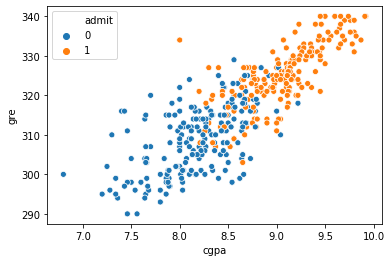

<IPython.core.display.Javascript object>

In [9]:
sns.scatterplot("cgpa", "gre", hue="admit", data=admission)
plt.show()

# Modeling

In [10]:
X = admission.drop(columns="admit")
y = admission["admit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

<IPython.core.display.Javascript object>

In [11]:
# fmt: off
bin_cols = ["research"]
num_cols = ["gre", "toefl", "school_rank", "sop", "lor", "cgpa"]

preprocessing = ColumnTransformer([
    ("scale", StandardScaler(), num_cols)
], remainder="passthrough")

<IPython.core.display.Javascript object>

## SVC

### Pipeline setup

In [12]:
# fmt: off
pipeline = Pipeline([
    ("preprocessing", preprocessing), 
    ("svc", SVC())
])
# fmt: on

grid = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2, 3],
    "svc__C": [0.001, 0.01, 0.1, 1.0],
}

pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

### Fit and eval

In [13]:
pipeline_cv.fit(X_train, y_train)

print("Best params:")
print(pipeline_cv.best_params_)

print(f"\ntrain score: {pipeline_cv.score(X_train, y_train):.3f}")
print(f"test score: {pipeline_cv.score(X_test, y_test):.3f}\n")

y_pred = pipeline_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 0.1, 'svc__degree': 2, 'svc__kernel': 'linear'}

train score: 0.878
test score: 0.875

[[38  4]
 [ 6 32]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.89      0.84      0.86        38

    accuracy                           0.88        80
   macro avg       0.88      0.87      0.87        80
weighted avg       0.88      0.88      0.87        80



<IPython.core.display.Javascript object>

### Feat importance

In [15]:
# Only if linear kernel is chosen
coef = pipeline_cv.best_estimator_["svc"].coef_[0]
im_df = pd.DataFrame({"feat": X_train.columns, "coef_sq": coef ** 2})
im_df.sort_values("coef_sq", ascending=False)

,feat,coef_sq
5,cgpa,0.632630
0,gre,0.244104
6,research,0.123721
2,school_rank,0.100121
4,lor,0.094635
1,toefl,0.029304
3,sop,0.018753


<IPython.core.display.Javascript object>

### Error analysis

mean prob of admit for errors: 0.749


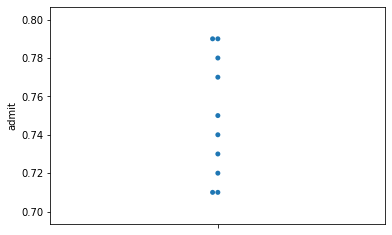

<IPython.core.display.Javascript object>

In [16]:
errors = admission_copy.copy()
errors = errors.loc[y_test.index, :]

errors["y_true"] = y_test
errors["y_pred"] = y_pred

errors = errors[errors["y_true"] != errors["y_pred"]]

# We based admit off of 0.73 if our errors have around that
# prob of admit then i feel we did pretty good
print(f'mean prob of admit for errors: {errors["admit"].mean()}')

sns.swarmplot(y=errors["admit"])
plt.show()

## XGBoost

### Pipeline setup

In [20]:
# fmt: off
n_trees = 100

pipeline = Pipeline([
    ("preprocessing", preprocessing), 
    ("xgb", XGBClassifier(n_estimators = n_trees, learning_rate=2 / n_trees))
])
# fmt: on

grid = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0],
    "xgb__max_depth": [2, 3, 4, 5],
}

pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

### Fit and eval

In [21]:
pipeline_cv.fit(X_train, y_train)

print("Best params:")
print(pipeline_cv.best_params_)

print(f"\ntrain score: {pipeline_cv.score(X_train, y_train):.3f}")
print(f"test score: {pipeline_cv.score(X_test, y_test):.3f}\n")

y_pred = pipeline_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'xgb__colsample_bytree': 0.75, 'xgb__max_depth': 4, 'xgb__subsample': 0.5}

train score: 0.903
test score: 0.875

[[39  3]
 [ 7 31]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.91      0.82      0.86        38

    accuracy                           0.88        80
   macro avg       0.88      0.87      0.87        80
weighted avg       0.88      0.88      0.87        80



<IPython.core.display.Javascript object>

### Feat importance

In [22]:
importances = pipeline_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
5,cgpa,0.358977
0,gre,0.179830
1,toefl,0.131125
2,school_rank,0.117858
4,lor,0.084819
6,research,0.066140
3,sop,0.061252


<IPython.core.display.Javascript object>

### Error analysis

mean prob of admit for errors: 0.749


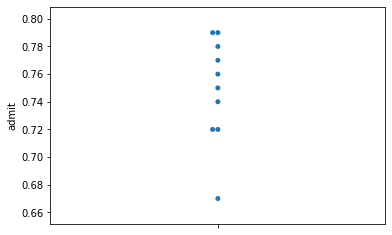

<IPython.core.display.Javascript object>

In [23]:
errors = admission_copy.copy()
errors = errors.loc[y_test.index, :]

errors["y_true"] = y_test
errors["y_pred"] = y_pred

errors = errors[errors["y_true"] != errors["y_pred"]]

# We based admit off of 0.73 if our errors have around that
# prob of admit then i feel we did pretty good
print(f'mean prob of admit for errors: {errors["admit"].mean()}')

sns.swarmplot(y=errors["admit"])
plt.show()